# PART II

This is a demonstration of <b>Approach I</b> described in the textual answer.

## THE DATASETS

### efficient transfomer
Another dataset, from the [Beyond Efficient Transformer paper](https://arxiv.org/pdf/2012.07436) obtained from
[ET REPO](https://github.com/zhouhaoyi/ETDataset)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from temperature_calculator.data.preprocessing import (
    convert_timestamp,
    create_trainable_data,
    generate_non_equidistant_sample
)

from temperature_calculator.models.training import (
    train_model,
    process_data_for_training,
)

from temperature_calculator.utils.constants import TIME, HOURS
from temperature_calculator.utils.datasets import load_et_temperature_data

In [2]:

ett_data = load_et_temperature_data()
df = convert_timestamp(
    df=ett_data,
    time_column_source=TIME,
    time_column_target=HOURS,
    verbose=True,
)

INFO:Temperature calculator:LOADING DATA FROM  datasets/ETDataset/ETT-small/ETTh1.csv
INFO:Temperature calculator:CONVERTING TIMESTAMP TO NUMERIC


In [3]:
df.head()

,time,temperature,hours
0,2016-07-01 00:00:00,30.531000,407588.0
1,2016-07-01 01:00:00,27.787001,407589.0
2,2016-07-01 02:00:00,27.787001,407590.0
3,2016-07-01 03:00:00,25.044001,407591.0
4,2016-07-01 04:00:00,21.948000,407592.0


<b> Demo </b> of model input and output

In [4]:
# MASK IS USED HERE ONLY FOR DEMO PURPOSES
from temperature_calculator.data.preprocessing import mask

In [5]:
demo_data = create_trainable_data(
    generate_non_equidistant_sample(
        df=df, 
        verbose=True, 
        time_column=HOURS, 
        frac=0.75,
    ), 
    verbose=True
)

INFO:Temperature calculator:GENERATING NON-EQUIDISTANT SAMPLE
INFO:Temperature calculator:DISTRIBUTION OF TIME GAPS
|	GAP	|	COUNT
------------------------------
|	1.0	|	9819
|	2.0	|	2411
|	3.0	|	628
|	4.0	|	157
|	5.0	|	34
|	6.0	|	10
|	7.0	|	5
INFO:Temperature calculator:EXTRACTING CONTINUOUS SEQUENCES FROM NON-EQUIDISTANT DATASET


In [6]:
demo_data.len_sequence.value_counts()

3     417
4     340
5     266
6     188
7     129
8     113
9      95
10     61
11     53
13     37
12     33
14     17
16     13
15     11
17      9
19      5
20      5
18      4
21      3
23      2
22      2
29      1
Name: len_sequence, dtype: int64

In [7]:
def plot_model_input_output(ix, data, sequence_len):
    model_output = np.array(demo_data[demo_data.len_sequence == sequence_len].temperature.values[ix])
    model_input = mask(model_output.reshape(sequence_len,1), 0.5, sequence_len).flatten()
    
    plt.plot(
        model_output, 
        label = 'model output', 
        color='lightsteelblue'
    )
    plt.plot(
        np.ma.masked_where(model_input<0, model_input)-0.1, 
        label='imitiation of missing values',
        color = 'red',
    )
    
    plt.title("AUTOENCODER INPUT AND OUTPUT")
    plt.legend()
    plt.show()

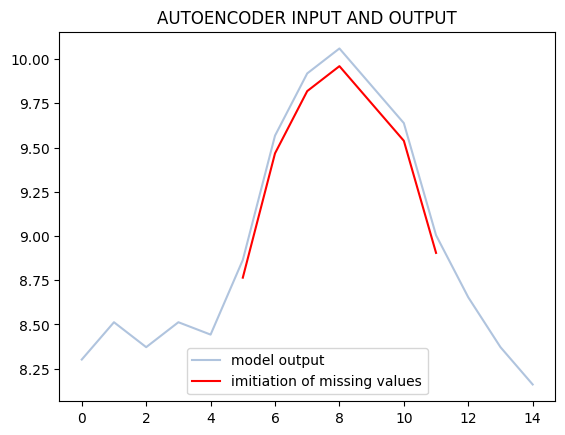

In [8]:
plot_model_input_output(ix=10, data=demo_data, sequence_len=15)

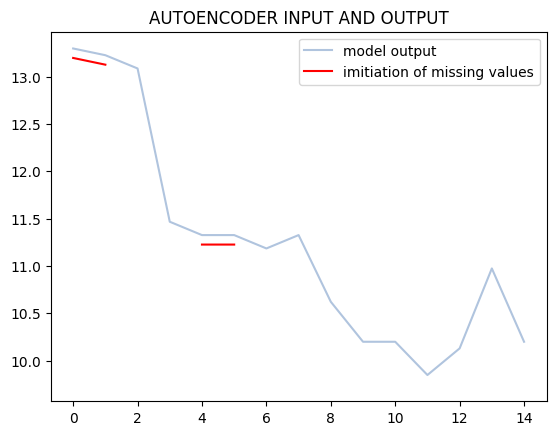

In [9]:
plot_model_input_output(ix=9, data=demo_data, sequence_len=15)

### Actual model training part

In [10]:
trainsample = generate_non_equidistant_sample(
        df=df, 
        verbose=True, 
        time_column=HOURS, 
        frac=0.5,
    )


INFO:Temperature calculator:GENERATING NON-EQUIDISTANT SAMPLE
INFO:Temperature calculator:DISTRIBUTION OF TIME GAPS
|	GAP	|	COUNT
------------------------------
|	1.0	|	4331
|	2.0	|	2183
|	3.0	|	1108
|	4.0	|	586
|	5.0	|	241
|	6.0	|	123
|	7.0	|	63
|	8.0	|	37
|	9.0	|	20
|	10.0	|	7
|	11.0	|	4
|	13.0	|	3
|	12.0	|	2
|	14.0	|	1


In [11]:
train_data = process_data_for_training(
    df=trainsample, 
    verbose=True, 
    len_ = 9, 
    frac=0.5,
)

INFO:Temperature calculator:EXTRACTING CONTINUOUS SEQUENCES FROM NON-EQUIDISTANT DATASET
INFO:Temperature calculator:CREATING TRAIN DATA
INFO:Temperature calculator:APPLYING INPUT STANDARDIZATION 


In [12]:
model = train_model(input_shape=9,
                    batch_size=3,
                    num_epochs=50,
                    **train_data
                    )

INFO:Temperature calculator:PREPARING TO TRAIN A MODEL ON DATA WITH SHAPE (3990, 9, 1)
INFO:Temperature calculator:CREATING AN LSTM-AUTOENCODER WITH INPUT LEN 9
INFO:Temperature calculator:	RETURNING THE AUTOENCODER
INFO:Temperature calculator:TRAINING STARTED


Epoch 1/10
1330/1330 [==============================] - 5s 3ms/step - loss: 35.5677 - val_loss: 24.9865
Epoch 2/10
1330/1330 [==============================] - 4s 3ms/step - loss: 25.5521 - val_loss: 23.1560
Epoch 3/10
1330/1330 [==============================] - 4s 3ms/step - loss: 24.3485 - val_loss: 21.3978
Epoch 4/10
1330/1330 [==============================] - 4s 3ms/step - loss: 23.6144 - val_loss: 23.9510
Epoch 5/10
1330/1330 [==============================] - 4s 3ms/step - loss: 23.6037 - val_loss: 21.4302
Epoch 6/10
1330/1330 [==============================] - 4s 3ms/step - loss: 23.0687 - val_loss: 21.5658
Epoch 7/10
1330/1330 [==============================] - 4s 3ms/step - loss: 22.8692 - val_loss: 20.9234
Epoch 8/10
1330/1330 [==============================] - 4s 3ms/step - loss: 23.5844 - val_loss: 21.9660
Epoch 9/10
1330/1330 [==============================] - 4s 3ms/step - loss: 22.6764 - val_loss: 20.4684
Epoch 10/10
1330/1330 [==============================] - 4s 3ms/

INFO:Temperature calculator:TRAINING FINISHED


In [25]:
from temperature_calculator.data.preprocessing import split
from temperature_calculator.data.preprocessing import split
from temperature_calculator.utils.constants import (
    TEMPERATURE, 
    INTERPOLATED, 
    PREDICTED,
    HOURS,
)


def get_model_outputs(model, df):
    df[HOURS] = df[HOURS].apply(int)
    input_df = pd.DataFrame(
        {
            HOURS: range(
                df.hours.min(),
                df.hours.max(),
                1,
            )
        }
    ).merge(
        df[[
            HOURS,
            TEMPERATURE,
        ]],
        on=HOURS,
        how='left',
    )
    input_df.temperature.fillna(-10, inplace=True)
    input_values = np.array(
        split(
            sequence_=input_df[TEMPERATURE].values,
            sublen=9
        )
    )

    result = model.predict(input_values)
    return result, input_df

In [26]:
results, input_df = get_model_outputs(model=model, df=trainsample)

544/544 [==============================] - 1s 2ms/step


In [29]:
def merge_modeloutput(input_df, result):
    result_as_df = pd.DataFrame([res.flatten() for res in result])
    result_as_df.columns = list(map(str, result_as_df.columns))
    prefix_ = "output_"
    for shift_val in range(0, 9):
        result_as_df[prefix_ + str(shift_val)] = result_as_df[str(shift_val)].shift(shift_val)
        
    input_df[PREDICTED] = result_as_df[[c for c in result_as_df.columns if prefix_ in c]].mean(axis=1)
    input_df[INTERPOLATED] = input_df.apply(
        lambda row: row[PREDICTED] if row[TEMPERATURE] == -10 else row[TEMPERATURE],
        axis=1
    )
    return input_df


In [30]:
interpolated = merge_modeloutput(input_df, results)

In [33]:
interpolated.rename(columns={"temperature":"input_temperature"}, inplace=True)

In [38]:
final = interpolated.merge(df, on="hours", how='left')[[INTERPOLATED, TEMPERATURE, HOURS, "input_temperature"]]

In [39]:
final.head()

,temperature_interpolated,temperature,hours,input_temperature
0,25.044001,25.044001,407591,25.044001
1,9.349383,21.948000,407592,-10.000000
2,4.713851,21.174000,407593,-10.000000
3,6.637488,22.792000,407594,-10.000000
4,23.143999,23.143999,407595,23.143999


In [41]:
abs(final["temperature_interpolated"]-final["temperature"]).describe()

count    17412.000000
mean         1.747997
std          3.045184
min          0.000000
25%          0.000000
50%          0.000000
75%          2.391000
max         33.052479
dtype: float64

# CONCLUSION
Even with small training it seems that the interpolation method achieves much better results as compared to either of the averages.